# Spatial Analysis in Geology using R

## by Pedro Nogueira

##  <span style="color:red;">15. Basic raster operations </span>

In [1]:
#15-00
# Settings

# Print the R version information
print(R.version)

# Verify thw working directory
wd_base = getwd()
print(wd_base)

               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          3.1                         
year           2023                        
month          06                          
day            16                          
svn rev        84548                       
language       R                           
version.string R version 4.3.1 (2023-06-16)
nickname       Beagle Scouts               
[1] "/Users/pnogasmacmini/Documents/Jupyter Notebooks/SAGR/Part II"


<span style="color:green;"> 
    <h2> 15.1 Reprojecting rasters </h2>
</span>

In [2]:
#15-01
# Load the library
library(elevatr)
library(raster)
library(sf)

# Retrieve the data
data(meuse.grid)
data(meuse)

# Convert the meuse.grid data to an sf object
sf_meuse.grid = st_as_sf(meuse.grid, coords = c("x", "y"))

# Assign the CRS to the sf object
st_crs(sf_meuse.grid) = 28992

# Create a raster from the meuse grid data
meuse_raster = raster(sf_meuse.grid)

# Retrieve elevation data for a larger region
elevation = get_elev_raster(meuse_raster, units= "meters" , src = "aws", z = 14)

# Reproject the elevation raster to the original projected CRS
elevation_wgs84 = projectRaster(elevation, crs = 4326)

# Show the information of the elevation raster in CRS=28992 format
format(res(elevation), scientific = FALSE)
ncell(elevation)
projection(elevation)

# Show the information of the elevation raster in WGS84
format(res(elevation_wgs84), scientific = FALSE)
ncell(elevation_wgs84)
projection(elevation_wgs84)

elevatr v0.99.0 NOTE: Version 0.99.0 of 'elevatr' uses 'sf' and 'terra'.  Use 
of the 'sp', 'raster', and underlying 'rgdal' packages by 'elevatr' is being 
deprecated; however, get_elev_raster continues to return a RasterLayer.  This 
will be dropped in future versions, so please plan accordingly.

Loading required package: sp

Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

Mosaicing & Projecting

Note: Elevation units are in meters.



[1] "3.009277" "3.009277"

[1] 3181646

[1] "+proj=sterea +lat_0=52.1561605555556 +lon_0=5.38763888888889 +k=0.9999079 +x_0=155000 +y_0=463000 +ellps=bessel +units=m +no_defs"

[1] "0.0000428" "0.0000271"

[1] 3258254

[1] "+proj=longlat +datum=WGS84 +no_defs"

<span style="color:green;"> 
    <h2> 15.2 Croping rasters </h2>
</span>

Warning message in plot.sf(meuse_sf, pch = 2, cex = 0.5, col = "red", add = TRUE):
“ignoring all but the first attribute”


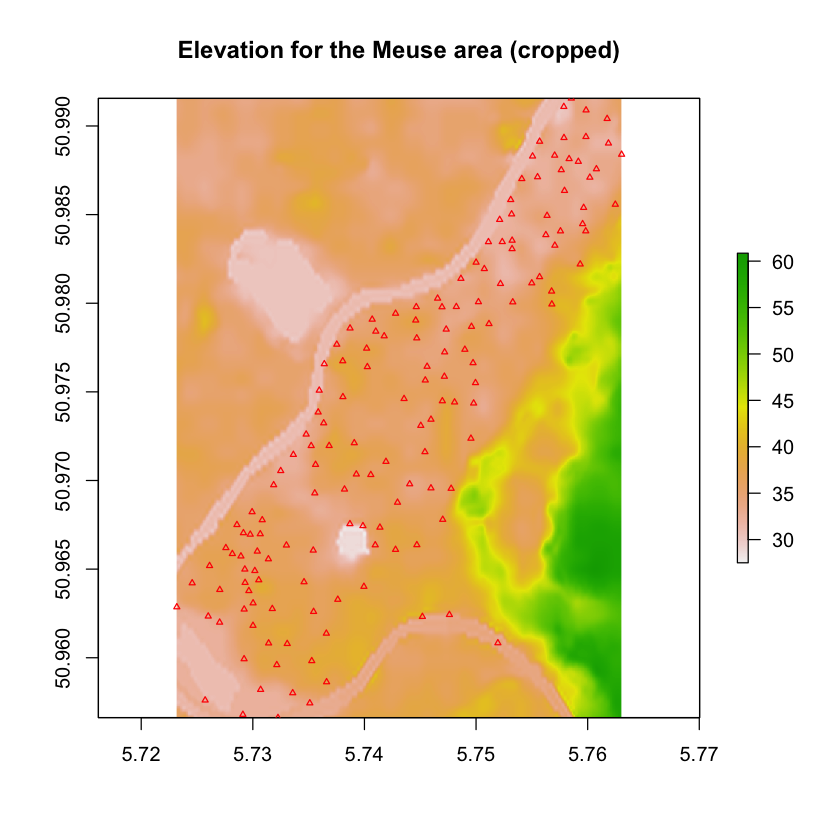

In [6]:
#15-02
# Define the meuse ‘sf’ dats
meuse_sf = st_as_sf(meuse, coords = c("x","y"), crs = 28992)

# Convert to wgs84
meuse_sf = st_transform(meuse_sf, crs = 4326)

# Crop the elevation raster to the extent of the shapefile
elevation_wgs84_crop = crop(elevation_wgs84, extent(meuse_sf))

# Plot the cropped and clipped elevation rasters
plot(elevation_wgs84_crop, main = "Elevation for the Meuse area (cropped)")
plot(meuse_sf, pch=2, cex=.5, col="red", add = TRUE)

<span style="color:green;"> 
    <h2> 15.3 Resampling raster data </h2>
</span>

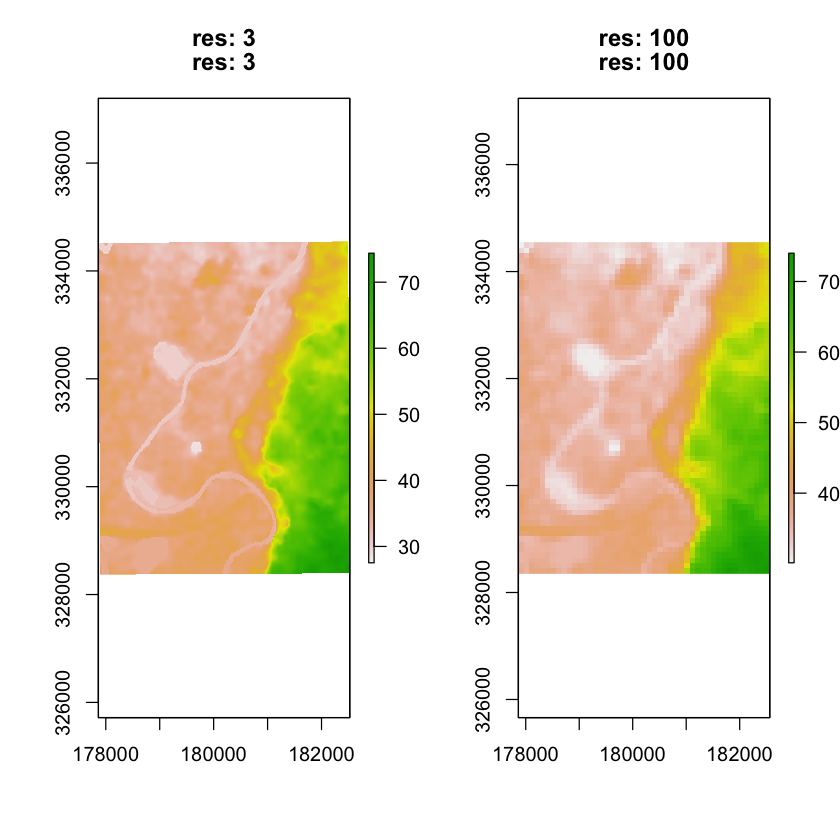

In [7]:
#15-03
# Define the new resolution and extent for the resampled raster
resolution = c(100, 100)
extent_data = extent(elevation)

# Create a new Raster object with the desired properties
raster_new = raster(ext = extent_data, res = resolution, crs = 28992, vals = NA)

# Resample the elevation raster to the desired resolution and extent
elevation_resampled = resample(elevation, raster_new, method = "bilinear")

# Plot the resampled elevation raster
par(mfrow=c(1,2))
plot(elevation, main=paste("res:",round(res(elevation),0)))
plot(elevation_resampled, main=paste("res:",round(res(elevation_resampled),0)))

<span style="color:green;"> 
    <h2> 15.4 Aggregating and disaggregating </h2>
</span>

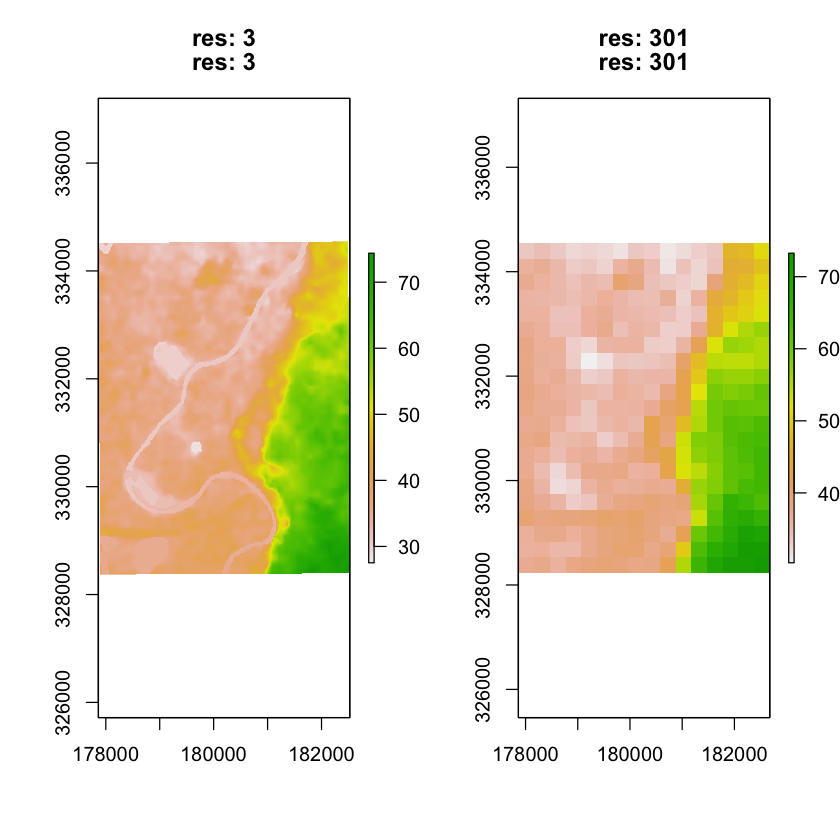

In [8]:
#15-04
# Coarsen the resolution of the elevation raster to approx. 300m
elevation_300m = aggregate(elevation, fact=300/3)

# Plot the resampled elevation raster
par(mfrow=c(1,2))
plot(elevation, main=paste("res:", round(res(elevation),0)))
plot(elevation_300m, main=paste("res:", round(res(elevation_300m),0)))

<span style="color:green;"> 
    <h2> 15.5 Filtering raster data </h2>
</span>

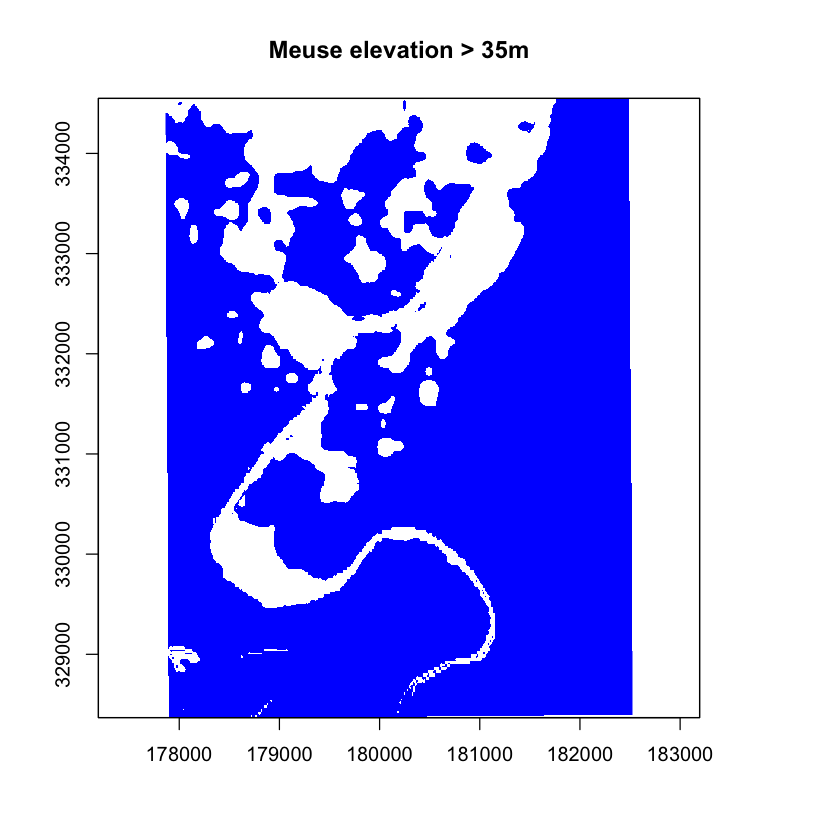

In [9]:
#15-05
# Filter the elevation raster based on the elevation
elevation_filtered = elevation > 35

# View the Results
par(mfrow=c(1,1))
plot(elevation_filtered, main = "Meuse elevation > 35m", col= c("white", "blue"), legend = FALSE)

<span style="color:green;"> 
    <h2> 15.6 Masking raster data </h2>
</span>

Data (c) OpenStreetMap contributors, ODbL 1.0. https://www.openstreetmap.org/copyright

Warning message in plot.sf(quarry, col = "red", add = TRUE):
“ignoring all but the first attribute”


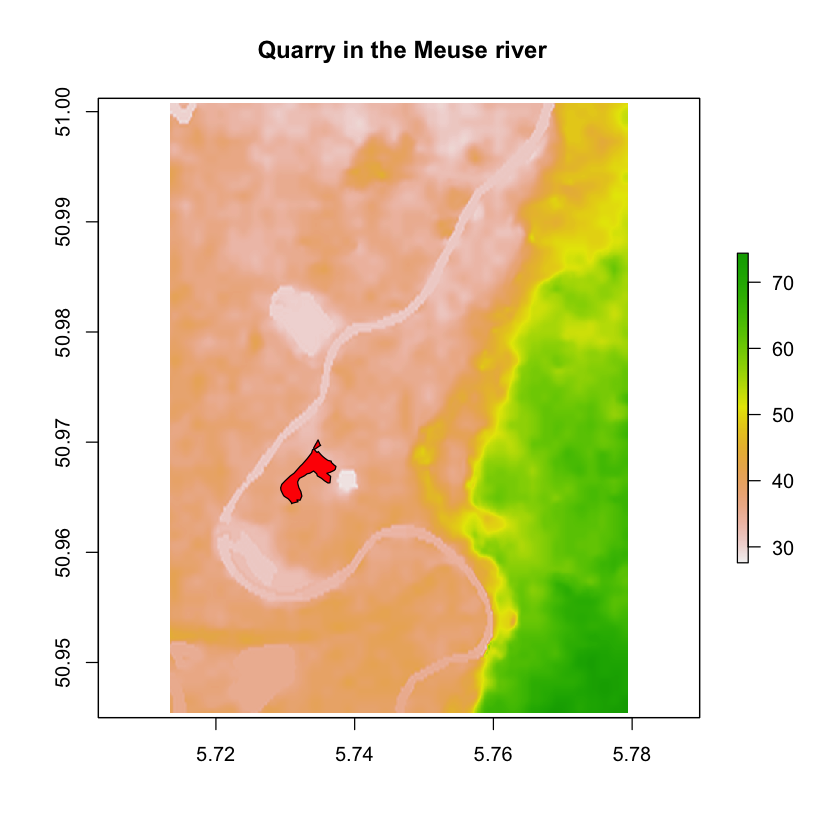

In [10]:
#15-06
# Load the library
library(osmdata)

# Use opq to fetch the OSM data for the quarry
osm_query = opq(bbox = getbb("Meers, Stein, Netherlands"))
osm_query_quarry = add_osm_feature(osm_query, key="landuse", value = "quarry")

# Retrieve the quarry
meers_quarry = osmdata_sf(osm_query_quarry)
quarry = meers_quarry$osm_polygons

# View the Quarry
par(mfrow=c(1,1))
plot(elevation_wgs84, main=" Quarry in the Meuse river")
plot(quarry, col = "red", add = TRUE)

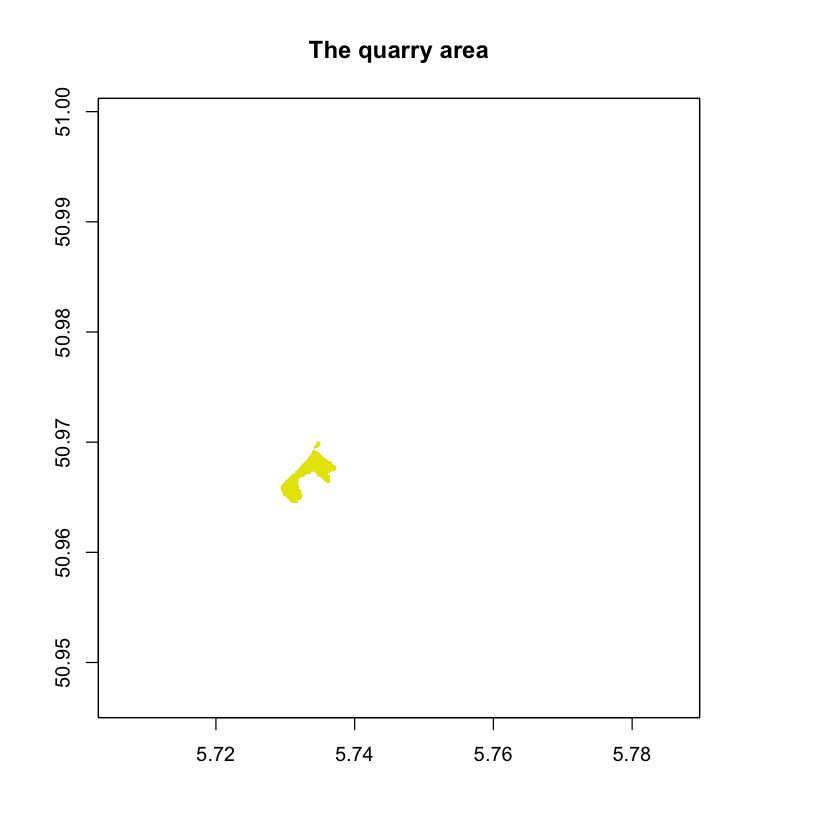

In [11]:
#15-07
# Rasterize the polygon
quarry_raster = rasterize(quarry, elevation_wgs84)

# View the result
plot(quarry_raster, main="The quarry area", legend = FALSE)

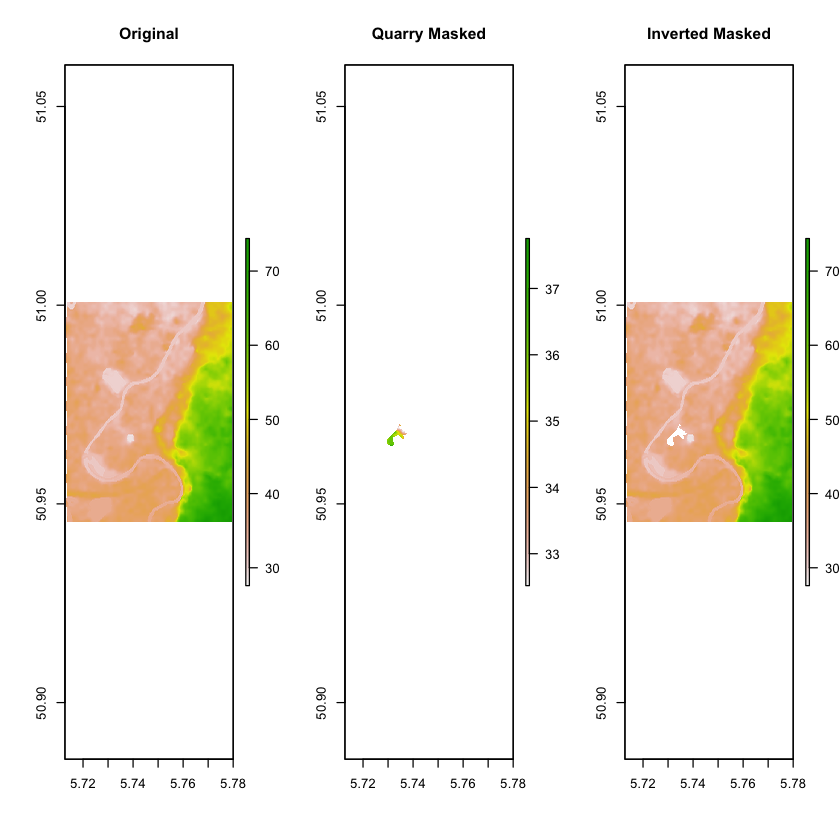

In [12]:
#15-08
# Only the Quarry masked
elevation_masked = mask(elevation_wgs84, quarry_raster)

# Invert the mask to only retain the cells outside of the quarry
mask = quarry_raster == 1

# Create a new raster that shows the elevation data in non-quarry areas and no data in quarry areas
elevation_inv = elevation_wgs84
elevation_inv[mask] = NA

# Plot the original elevation data and the masked elevation data
par(mfrow=c(1,3))
plot(elevation_wgs84, main = "Original")
plot(elevation_masked, main = "Quarry Masked")
plot(elevation_inv, main = "Inverted Masked")

<span style="color:blue;"> 
    <h1> References </h1>
</span>

Nothing to refer...